<a href="https://colab.research.google.com/github/philipiak3/MachineLearning_PneumoniaDetection/blob/main/Machine_Learning_for_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from google.colab.patches import cv2_imshow
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, SeparableConv2D, Input, MaxPool2D
from keras.utils import to_categorical, plot_model
from keras.applications.densenet import preprocess_input
from keras.applications import EfficientNetB0
from keras.preprocessing import image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
from tensorflow.keras.optimizers import AdamW

In [ ]:
# Set the path to "train_images" folder and "labels_train" CSV file

path = '/content/drive/MyDrive/train_images'
labels_path = '/content/drive/MyDrive/labels_train.csv'
test_path = '/content/drive/MyDrive/test_images'

In [ ]:
# Load the labels from the CSV file

labels_df = pd.read_csv(labels_path)
labels_dict = dict(zip(labels_df['file_name'], labels_df['class_id']))

In [ ]:
# Create a list to store images and labels

images = []
labels = []

In [ ]:
# Loop through the images in the folder

for filename in tqdm(os.listdir(path)):
    # Load the image and resize it
    img = cv2.imread(os.path.join(path,filename))
    img = cv2.resize(img, (224, 224))

    # Get the label from the dictionary using the image name as the key
    label = labels_dict[filename]

    # Append the image and label to the lists
    images.append(img)
    labels.append(label)

  0%|          | 0/4672 [00:00<?, ?it/s]

In [ ]:
test_images = []
test_file_names = []

# Loop through the images in the folder

for filename in tqdm(os.listdir(test_path)):
    # Load the image and resize it
    test_img = cv2.imread(os.path.join(test_path,filename))
    test_img = cv2.resize(test_img, (224, 224))

    # Append the image to the lists
    test_images.append(test_img)
    test_file_names.append(filename)

  0%|          | 0/1168 [00:00<?, ?it/s]

In [ ]:
# Convert the images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)
test_images = np.array(test_images)

# Print the shape of the arrays
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)
print("Shape of test images:", test_images.shape)

Shape of images: (4672, 224, 224, 3)
Shape of labels: (4672,)
Shape of test images: (1168, 224, 224, 3)


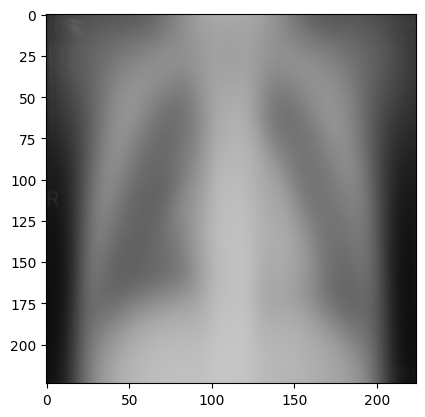

In [ ]:

# Normalize data
images = images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Subtract pixel mean
images_mean = np.mean(images, axis=0)
images -= images_mean
test_images -= images_mean

plt.imshow(images_mean)

In [ ]:
# Model 1
# Load the EfficientNetB0 pre-trained weights without the top (classification) layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pretrained weights
base_model.trainable = False

# Model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(3, activation='softmax'))

# Unfreeze the 9 last layers
for layer in model.layers[:-9]:
    layer.trainable=False

for layer in model.layers[-9:]:
    layer.trainable=True

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, verbose=2, mode='max')


In [ ]:

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=40)

# Train the model (16 batch size)
history = model.fit(train_images, train_labels, epochs=18, batch_size=16, validation_data=(val_images, val_labels),  callbacks=[checkpoint, lr_reduce])

Epoch 1/18
234/234 [==============================] - 85s 150ms/step - loss: 0.5551 - accuracy: 0.7642 - val_loss: 1.1979 - val_accuracy: 0.2610 - lr: 5.0000e-04
Epoch 2/18
234/234 [==============================] - 32s 135ms/step - loss: 0.4133 - accuracy: 0.8314 - val_loss: 1.3526 - val_accuracy: 0.2631 - lr: 5.0000e-04
Epoch 3/18
234/234 [==============================] - 32s 137ms/step - loss: 0.3185 - accuracy: 0.8726 - val_loss: 5.1146 - val_accuracy: 0.4406 - lr: 5.0000e-04
Epoch 4/18
234/234 [==============================] - ETA: 0s - loss: 0.2292 - accuracy: 0.9098
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
234/234 [==============================] - 32s 137ms/step - loss: 0.2292 - accuracy: 0.9098 - val_loss: 1.2250 - val_accuracy: 0.2610 - lr: 5.0000e-04
Epoch 5/18
234/234 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9690
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.500000213738531e-05.
234/234 [==========

In [ ]:
# Model 2
# Load the EfficientNetB0 pre-trained weights without the top (classification) layer
base_model3 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pretrained weights
base_model3.trainable = False

# Model
model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(3, activation='softmax'))

# Unfreeze the 9 last layers
for layer in model3.layers[:-9]:
    layer.trainable=False

for layer in model3.layers[-9:]:
    layer.trainable=True

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
# Callbacks
checkpoint3 = ModelCheckpoint(filepath='best_weights3.hdf5', save_best_only=True, save_weights_only=True)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, verbose=2, mode='max')


In [ ]:

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=40)

# Train the model (32 batch size)
history3 = model3.fit(train_images, train_labels, epochs=20, batch_size=32, validation_data=(val_images, val_labels),  callbacks=[checkpoint3, lr_reduce])

Epoch 1/20
117/117 [==============================] - 72s 294ms/step - loss: 0.5298 - accuracy: 0.7846 - val_loss: 1.4113 - val_accuracy: 0.2610 - lr: 5.0000e-04
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.8598
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
117/117 [==============================] - 31s 268ms/step - loss: 0.3558 - accuracy: 0.8598 - val_loss: 1.2759 - val_accuracy: 0.2610 - lr: 5.0000e-04
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9227
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.500000213738531e-05.
117/117 [==============================] - 31s 265ms/step - loss: 0.2069 - accuracy: 0.9227 - val_loss: 1.3709 - val_accuracy: 0.2620 - lr: 1.5000e-04
Epoch 4/20
117/117 [==============================] - 31s 266ms/step - loss: 0.1102 - accuracy: 0.9666 - val_loss: 1.5399 - val_accuracy: 0.3144 - lr: 4.5000e-05
Epoch 5/20
117/117 [==========

In [ ]:
# Model 3
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Load the DenseNet121 pre-trained weights without the top (classification) layer
base_model4 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model so that they are not updated during training
base_model4.trainable = False

# Add few extra layers including dropout
x = GlobalAveragePooling2D()(base_model4.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

# Create the model
model4 = Model(inputs=base_model4.input, outputs=output)

# Determine the number of layers to freeze from the beginning
num_layers_to_freeze = 5

# Freeze the early layers
for layer in model4.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Unfreeze the remaining layers
for layer in model4.layers[num_layers_to_freeze:]:
    layer.trainable = True

# Callbacks
checkpoint4 = ModelCheckpoint(filepath='best_weights4.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model4.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model4.summary()

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=40)

# Train the model
history4 = model4.fit(train_images, train_labels, epochs=18, batch_size=16, validation_data=(val_images, val_labels), callbacks=[checkpoint4, lr_reduce])


29084464/29084464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_4[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
# Model 4


# Load the DenseNet121 pre-trained weights without the top (classification) layer
base_model5 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model so that they are not updated during training
base_model5.trainable = False

# Add your own classification head
x = GlobalAveragePooling2D()(base_model5.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

# Create the model
model5 = Model(inputs=base_model5.input, outputs=output)

# Determine the number of layers to freeze from the beginning
num_layers_to_freeze = 4

# Freeze the early layers
for layer in model5.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Unfreeze the remaining layers
for layer in model5.layers[num_layers_to_freeze:]:
    layer.trainable = True

# Callbacks
checkpoint5 = ModelCheckpoint(filepath='best_weights5.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model5.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model5.summary()

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=40)

# Train the model
history5 = model5.fit(train_images, train_labels, epochs=18, batch_size=32, validation_data=(val_images, val_labels), callbacks=[checkpoint5, lr_reduce])


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
# Load the best weights
model.load_weights('best_weights.hdf5')
model3.load_weights('best_weights3.hdf5')
model4.load_weights('best_weights4.hdf5')
model5.load_weights('best_weights5.hdf5')


# Make predictions on the test images
predictions = model.predict(test_images)
predictions3 = model3.predict(test_images)
predictions4 = model4.predict(test_images)
predictions5 = model5.predict(test_images)


37/37 [==============================] - 5s 88ms/step


In [ ]:
ensemble_pred = (predictions + predictions3 + predictions4 + predictions5 ) / 4

In [ ]:
ensemble_labels = np.argmax(ensemble_pred, axis=1)

In [ ]:
# Create a DataFrame with the image names and predicted labels
results_df = pd.DataFrame({'file_name': test_file_names, 'class_id': ensemble_labels})

In [ ]:
# Save the DataFrame to a CSV file
results_csv_path = '/content/drive/MyDrive/b0-densenetx2.csv'
results_df.to_csv(results_csv_path, index=False)

print('Test results saved to', results_csv_path)

Test results saved to /content/drive/MyDrive/b0-densenetx2.csv
